~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Treatment: 20fractions
Patients: [   213    231    257    292    626    695   1464 106958 251842 312108]
####################################################
Patient: 0000213
Scan: MR4
Raw


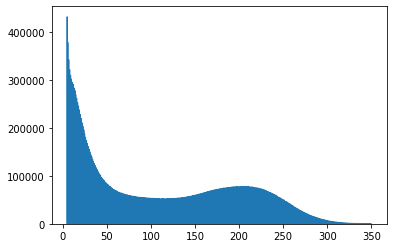

HM-TP


KeyboardInterrupt: 

In [2]:
from pydoc import pathdirs
import SimpleITK as sitk
from matplotlib.pyplot import contour
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import UsefulFunctions as UF
import ImageFunctions as IF
from datetime import datetime
import radiomics
from radiomics import featureextractor

#root = UF.DataRoot()
root = "D:\\data\\"

key_df = pd.read_csv(os.path.join(root, "Aaron\\ProstateMRL\\Data\\MRLPacks\\All_PatientKey.csv"))
nifti_dir = os.path.join(root, "prostateMR_radiomics\\nifti\\")
output_dir = os.path.join(root, "Aaron\\ProstateMRL\\Data\\MRLPacks\\Features_v3\\")

parameters = root + "Aaron\\ProstateMRL\\Data\\MRLPacks\\ExtractionParams\\All.yaml"
extractor = featureextractor.RadiomicsFeatureExtractor(parameters)

t_dir = key_df.FileDir.unique()

for t in t_dir: 
    t_df = key_df.loc[key_df["FileDir"] == t]
    patIDs = t_df.PatID.unique()
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Treatment: {}".format(t))
    print("Patients: {}".format(patIDs))

    for i in patIDs:
        pat_df = t_df[t_df["PatID"].isin([i])]
        patID = UF.FixPatID(i,t)
        scans = pat_df.Scan.unique()
        print("####################################################")
        print("Patient: {}".format(patID))
       
        dates = pat_df.Date.unique()

        first_date = dates[0]
        first_date = UF.FixDate(first_date)      
        
        p_df = pd.DataFrame()

        for j in scans:
            MRcont = j 
            pat_path = os.path.join(nifti_dir, t, patID, MRcont)

            scan_df = pat_df.loc[pat_df["Scan"] == (MRcont)]
            scan_date = str(scan_df.iloc[0]["Date"])
            scan_date = UF.FixDate(scan_date)
            days_diff = (scan_date - first_date).days

            print("Scan: {}".format(MRcont))


            mask_path, mask_labels, image_paths, image_labels = UF.GetNiftiPaths(pat_path, t)
            #image_paths = image_paths[1:4]
            #image_labels = image_labels[1:4]

            for k in range(len(image_paths)):
                
                folder = image_paths[k]
                label = image_labels[k]
                print(label)
                image_path, image_name = UF.GetImageFile(folder, patID, MRcont, label)

                norm = UF.GetNorm(image_name)

                values = {}
                
                mask_file = patID + "_" + MRcont + "_shrunk_pros.nii"
                mask_file_path = os.path.join(mask_path, mask_file)
                mask_value = IF.MaskValue("shrunk_pros")
                bm_file = patID + "_" + MRcont + "_body_mask.nii"
                bm_path = os.path.join(mask_path, bm_file)
                
                image = sitk.ReadImage(image_path)
                bm = sitk.ReadImage(bm_path)
                bm_arr = sitk.GetArrayFromImage(bm)
                image_arr = (sitk.GetArrayFromImage(image) * bm_arr)
                mask = sitk.ReadImage(mask_file_path)
                mask_arr = ((sitk.GetArrayFromImage(mask) / mask_value) * image_arr)

                image_arr = image_arr.flatten()
                mask_arr = mask_arr.flatten()

                plt.hist(image_arr, bins=2000
                ,range=(5,350), histtype="step", fill=False)
                #plt.hist(mask_arr, bins=256, range=(0,350), histtype="stepfilled")
                plt.show()
        #         temp_df = pd.DataFrame()
        #         temp_results = pd.Series(extractor.execute(image_path, mask_file_path, label=mask_value))
        #         temp_df = temp_df.append(temp_results, ignore_index=True)
                
        #         temp_df.insert(0, "PatID", patID)
        #         temp_df.insert(1, "Treatment", t)
        #         temp_df.insert(2, "Scan", MRcont)
        #         temp_df.insert(3, "DaysDiff", int(days_diff))
        #         temp_df.insert(4, "Normalisation", norm)
                
        #         p_df = p_df.append(temp_df, ignore_index=True)
                                       

        # p_df.to_csv(output_dir + t + "_" + patID  + "_HM.csv")

               

            



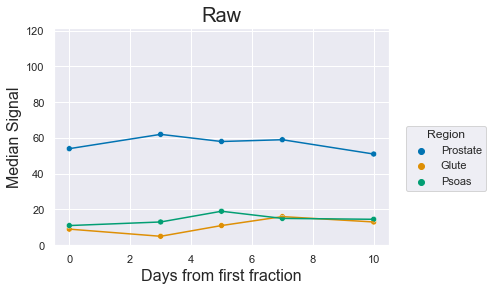

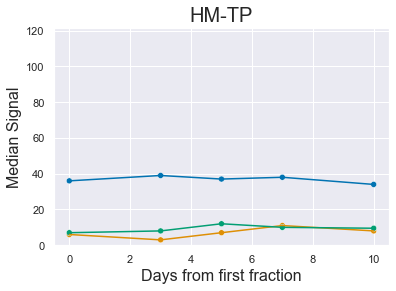

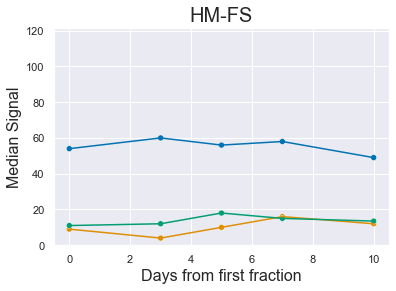

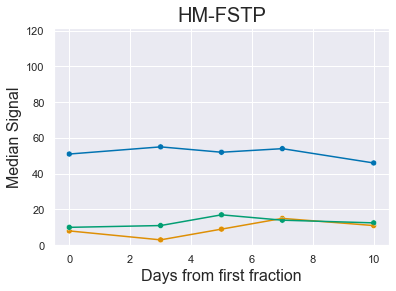

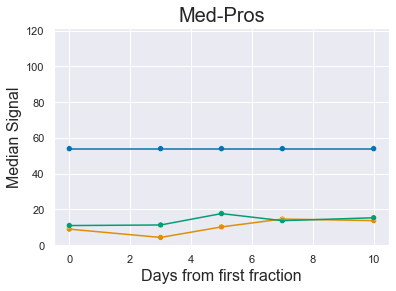

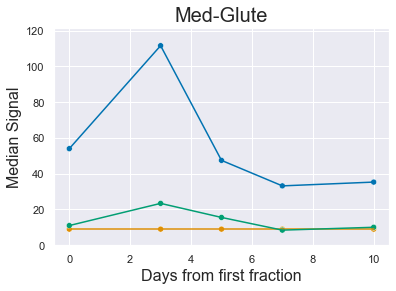

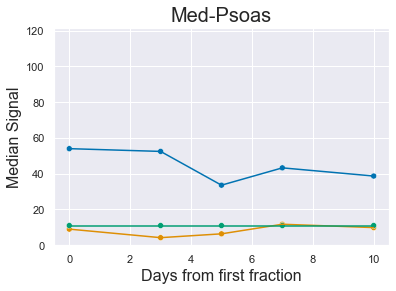

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_all = pd.read_csv("D:\data\Aaron\ProstateMRL\Data\MRLPacks\\SigPlot\\SABR_new_1029_Signal.csv")
#print(df_all)

df_all = df_all[["PatID", "DaysDiff", "Normalisation", "Region", "original_firstorder_Median"]]
df_all = df_all[df_all.Normalisation != "Norm-Pros"]#, "Norm-Glute", "Norm-Psoas"]]
df_all = df_all[df_all.Normalisation != "Norm-Psoas"]
df_all = df_all[df_all.Normalisation != "Norm-Glute"]#print(df_all.columns)
norms = df_all.Normalisation.unique()
Regions = df_all.Region.unique()
rgb_vals = sns.color_palette("colorblind", len(Regions))
colourmap = dict(zip(Regions, rgb_vals))
sns.set_theme(style='darkgrid')

y_max = df_all.original_firstorder_Median.max()

for n in norms:
    df_n = df_all.loc[df_all["Normalisation"] == n] 
    #df_n.rename(columns={"original_firstorder_Median": "Median"})
    #print(df_n)
    #df_n["DaysDiff"] = df_n.index
    #print(df_n["DaysDiff"])
    #fig, axes = plt.plots(figsize=(25,15))
    if n == "Raw":
        leg = True
    else: 
        leg = False
    plot1 = sns.lineplot(x = df_n["DaysDiff"], y = df_n["original_firstorder_Median"], hue=df_n["Region"], palette=colourmap, legend=False)
    plot2 = sns.scatterplot(x = df_n["DaysDiff"], y = df_n["original_firstorder_Median"], hue=df_n["Region"], palette=colourmap, legend=leg)
    plt.title(n, fontsize=20)
    plt.xlabel("Days from first fraction", fontsize = 16)
    plt.ylabel("Median Signal", fontsize = 16)
    plt.ylim(0,y_max + 10)
    if n == "Raw":
        plt.legend(title = "Region", bbox_to_anchor=(1.05, 0.55), loc='upper left', borderaxespad=0)
    
    plt.savefig("D:\data\Aaron\ProstateMRL\Data\MRLPacks\\SigPlot\\1029_" + n + "2.png", bbox_inches = "tight")
    plt.show()
    plt.clf()




        


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import UsefulFunctions as UF

Norms = UF.NormArray()
patIDs = UF.SABRPats()
Norms = Norms[0:2]
pat = "653"
cluster_type = "AffinityPropagation"
#cluster_type = "Agglomerative"

for n in tqdm(Norms):
    # csv containing all ft vals for each patient per norm
    ft_vals = pd.read_csv("D:\\data\\Aaron\\ProstateMRL\\Data\\MRLPacks\\VolIndFts\\" + n + ".csv")
    ft_vals["PatID"] = ft_vals["PatID"].astype(str)
    pat_ft_vals = pd.DataFrame()

    # for pat in patIDs:
    #     # get patient values
    pat_ft_vals = ft_vals[ft_vals["PatID"] == pat]

    pat_ft_labels = pd.read_csv("D:\data\Aaron\ProstateMRL\Data\MRLPacks\\Clustering\\" + cluster_type + "\\Labels\\" + pat + "_" + n + "_ClusterLabel.csv")
    pat_ft_labels.set_index('FeatureName', inplace=True)
    # merge
    pat_ft_vals = pat_ft_vals.merge(pat_ft_labels, left_on="FeatureName", right_on="FeatureName")
    
    print(n, (pat_ft_vals["Cluster"].max() + 1))

    

100%|██████████| 2/2 [00:00<00:00,  9.70it/s]

Raw 11
HM-FS 10


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import sklearn.metrics as metrics
import sklearn.cluster as sc
from scipy.cluster.hierarchy import dendrogram
import UsefulFunctions as UF
import scipy.cluster.hierarchy as spch
import scipy.signal as ssc

Norms = UF.NormArray()
patIDs = UF.SABRPats()

#cluster_type = "AffinityPropagation"
cluster_type = "Agglomerative"

csv_dir = "D:\\data\\Aaron\\ProstateMRL\\Data\\MRLPacks\\DistanceMatrices\\csvs\\"

# for n in tqdm(Norms):
pat = "829"
n = "Med-Pros"
# for pat in patIDs:
        # Read in distance matrix for each patient and norm
for pat in patIDs:
        df_DM = pd.read_csv(csv_dir + pat + "_" + n + "_DM.csv")
        df_DM = df_DM.drop(columns=['Unnamed: 0'])

        # Cluster
        arr_DM = df_DM.to_numpy()
        fts = df_DM.columns
        df_labels = pd.DataFrame()
        df_labels["FeatureName"] = fts
        df_labels["Cluster"] = spch.fclusterdata(arr_DM, t=2, criterion="distance", method="weighted")
        df_labels.set_index("FeatureName", inplace=True)
        #print(df_labels.Cluster.value_counts)

        ft_vals = pd.read_csv("D:\\data\\Aaron\\ProstateMRL\\Data\\MRLPacks\\VolIndFts\\" + n + ".csv")
        ft_vals["PatID"] = ft_vals["PatID"].astype(str)

        pat_ft_vals = ft_vals[ft_vals["PatID"] == pat]

        pat_ft_vals = pat_ft_vals.merge(df_labels, left_on="FeatureName", right_on="FeatureName")

        # plt.figure(figsize=(10, 7))
        # g = sns.FacetGrid(pat_ft_vals, col = "Cluster", col_wrap=4)
        # g.tight_layout()
        # g.fig.suptitle("{} {}".format(pat, n), fontsize=40)
        # g.map_dataframe(sns.scatterplot, x="DaysDiff", y="FeatureChange", hue="FeatureName")
        # g.map_dataframe(sns.lineplot, x="DaysDiff", y="FeatureChange", hue="FeatureName")
        # #g.savefig("D:\data\Aaron\ProstateMRL\Data\MRLPacks\\Clustering\\" + cluster_type + "\\SignalPlots\\" + pat + "_" + n + "_SignalCluster.png")
        # plt.show()
        # pat_ft_vals2 = pat_ft_vals.groupby(by="FeatureName")
        # #print(pat_ft_vals.Cluster.value_counts())


In [ ]:
import scipy.signal 
import statsmodels.tsa.stattools as sts

#f = "firstorder_Entropy"
cluster_max = pat_ft_vals["Cluster"].max()

for c in range(1, cluster_max):
    temp = pat_ft_vals[pat_ft_vals["Cluster"] == c]
    fts = temp.FeatureName.unique() 
    num_fts = len(fts)
    print("Cluster: {}".format(c))
    print("Features: {}".format(num_fts))

    if num_fts > 2:
       
        vals = {}

        for f in fts:
            temp2 = temp[temp["FeatureName"] == f]
            v = temp2.FeatureChange.values
            vals[f]= v
        print(vals)
        #print(vals)
        ccfs = {}
        mean_ccfs = []
        for v in vals:
            #print(v)
            #print(vals[v])
            ft1 = vals[v]
            ccfs[v] = v
            ccfs_val = []
            
            for f in vals:
                ft2 = vals[f]
                #print("{} + {}: {}".format(v,f,np.correlate(ft1, ft2)))
                #print("{} + {}: {}".format(v,f,sts.ccf(ft1,ft2)[0]))
                ccfs_val.append(sts.ccf(ft1,ft2)[0])
            mean_ccfs.append(np.array(ccfs_val).mean())

        #print(vals)
        #print(ccfs)
        #print(fts)
        #print(mean_ccfs)
        print("Selected Feature: {} - {}".format(fts[np.argmax(np.array(mean_ccfs))], np.array(mean_ccfs).max()))

    else: 
        print("Not enough features")

    plt.figure(figsize=(10, 10))
    g = sns.FacetGrid(temp, col = "Cluster", col_wrap=1)
    g.tight_layout()
    g.fig.suptitle("{} {}".format(pat, n), fontsize=20)
    g.map_dataframe(sns.scatterplot, x="DaysDiff", y="FeatureChange", hue="FeatureName")
    g.map_dataframe(sns.lineplot, x="DaysDiff", y="FeatureChange", hue="FeatureName", legend=False)
    plt.legend(title = "Feature", bbox_to_anchor=(1.05, 0.55), loc='upper left', borderaxespad=0)

    #g.savefig("D:\data\Aaron\ProstateMRL\Data\MRLPacks\\Clustering\\" + cluster_type + "\\SignalPlots\\" + pat + "_" + n + "_SignalCluster.png")
    #plt.show()


In [19]:
import UsefulFunctions as UF

cluster_max = pat_ft_vals["Cluster"].max()
fts_selected = []
result_df = pd.DataFrame()

for c in range(1, cluster_max):
    row = {}
    cluster_df = pat_ft_vals[pat_ft_vals["Cluster"] == c]
    
    ft_selected = UF.ClusterFtSelection(cluster_df)

    fts_selected.append(ft_selected)
    
    row["pat"] = pat
    row["Feature"] = ft_selected
    row["Cluster"] = c

    result_df = result_df.append(row, ignore_index = True)



fts_selected = [x for x in fts_selected if str(x) != "nan"]
#print(fts_selected)

result_df = result_df.set_index("pat")
result_df = result_df.dropna()
print(result_df)



# cluster_results["PatID"] = cluster_df.PatID.unqiue
# cluster_results["Norm"] = n
# cluster_results["Ft_"]




    

    

    #print(pat_ft_vals[pat_ft_vals["FeatureName"] == ft_selected])



Cluster Number: [1]
Less than 2 features
Cluster Number: [2]
Number of fts: 3
Cluster Number: [3]
Number of fts: 6
Cluster Number: [4]
Number of fts: 3
Cluster Number: [5]
Less than 2 features
Cluster Number: [6]
Number of fts: 7
Cluster Number: [7]
Number of fts: 8
Cluster Number: [8]
Number of fts: 15


d:\data\Aaron\ProstateMRL\py-envs\lib\site-packages\statsmodels\tsa\stattools.py:1140: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))


Cluster Number: [9]
Number of fts: 26
     Cluster                         Feature
pat                                         
955      2.0               glrlm_RunVariance
955      3.0         firstorder_10Percentile
955      4.0           glrlm_LongRunEmphasis
955      6.0         glrlm_GrayLevelVariance
955      7.0             firstorder_Kurtosis
955      8.0  glrlm_HighGrayLevelRunEmphasis
955      9.0               glcm_JointEntropy


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import UsefulFunctions as UF

csv_dir =  "D:\\data\\Aaron\\ProstateMRL\\Data\\MRLPacks\\Clustering\\Agglomerative\\SelectedFts\\"

Norms = UF.NormArray()#[0:1]
patIDs = UF.SABRPats()
t_val = "2"

for n in Norms:
    print(n)
    df_all = pd.DataFrame()
    for p in patIDs:
        df_pat = pd.read_csv(csv_dir + p + "_" + n +"_test.csv")# + t_val + "_FinalFts.csv")
        #print(df_pat.shape)

        df_all = df_all.append(df_pat)
    #print(df_all.Ft.value_counts())
    plt.figure(figsize=(20,15))
    sns.set(font_scale = 0.8)
    df_all.Ft.value_counts().plot(kind="barh")
    plt.show()

In [ ]:
import pandas as pd
from tqdm import tqdm
import UsefulFunctions as UF
import numpy as np

labels_dir = "D:\\data\\Aaron\\ProstateMRL\\Data\\MRLPacks\\Clustering\\Agglomerative\\Labels\\"

Norms = UF.NormArray()
patIDs = UF.SABRPats()

Norms = Norms[0:1]

for n in Norms:
    df_all = pd.DataFrame()
    df_pat = pd.read_csv(labels_dir + patIDs[0] + "_" + n + "_t2_ward.csv")

    fts = df_pat.FeatureName.unique()
        
    matrix = np.zeros((len(fts),len(fts)))
    
    for pat in patIDs:
        df_pat = pd.read_csv(labels_dir + pat + "_" + n + "_t2_ward.csv")
        df_pat = df_pat[["PatID", "FeatureName", "Cluster"]]
        df_pat = df_pat.drop_duplicates()

        fts = df_pat.FeatureName.unique()
        
        for i in range(len(fts)):
            for j in range(len(fts)):
                ft1 = fts[i]
                ft2 = fts[j]
                #print(df_pat[df_pat["FeatureName"] == ft1])
                ft1_c = df_pat[df_pat["FeatureName"] == ft1]["Cluster"].values[0]
                ft2_c = df_pat[df_pat["FeatureName"] == ft2]["Cluster"].values[0]

                if ft1_c == ft2_c:
                    matrix[i,j] = matrix[i,j] + 1
                else:
                    matrix[i,j] = matrix[i,j]

        df_matrix = pd.DataFrame(matrix, columns=fts, index=fts)

        plt.figure(figsize=(20,20))
        sns.set_theme(style = "white")
        #plt.title("DM {} {}".format(pat, n), fontsize = 40)
        sns.heatmap(df_matrix, cmap='viridis', cbar_kws={'label': 'Pair-wise counts'})
        plt.show()




In [46]:
dic = {}
for i in range(10):
    dic[i] = np.random.randint(10,100)

print(dic)

sort = sorted(dic.items(), key=lambda x:x[1], reverse=True)
print(sort)

mine = sort[0:4]
print(mine)

actual = [seq[0] for seq in mine]
print(actual)

{0: 11, 1: 53, 2: 92, 3: 26, 4: 89, 5: 40, 6: 91, 7: 78, 8: 59, 9: 70}
[(2, 92), (6, 91), (4, 89), (7, 78), (9, 70), (8, 59), (1, 53), (5, 40), (3, 26), (0, 11)]
[(2, 92), (6, 91), (4, 89), (7, 78)]
[2, 6, 4, 7]


In [20]:
from asyncio.windows_events import NULL
import pandas as pd
import numpy as np
from tqdm import tqdm
import UsefulFunctions as UF
import matplotlib.pyplot as plt
import seaborn as sns

Norms = UF.NormArray()[0:1]
patIDs = UF.SABRPats()

csv_dir = "D:\\data\\Aaron\\ProstateMRL\\Data\\MRLPacks\\Clustering\\Agglomerative\\Labels\\"
out_dir =  "D:\\data\\Aaron\\ProstateMRL\\Data\\MRLPacks\\Clustering\\Agglomerative\\SelectedFts2\\"

t_val = "2"
cluster_method = "weighted"


def ClusterSimilarity2(fts_1, fts_2):
    '''
    
    '''
    fts_1, fts_2 = list(fts_1), list(fts_2)
    sim_fts = set(fts_1) & set(fts_2)
    num_sim_fts = len(sim_fts)
    if len(fts_1) != 0 and len(fts_2) != 0:
        ratio_a  = len(sim_fts) / len(fts_1)
        
        ratio_b = len(sim_fts) / len(fts_2)

        ratio = (ratio_a - ratio_b) 
        #print(ratio_a, ratio_b, ratio)
    else: 
        ratio, ratio_a, ratio_b = 1,1,1
    
    return(num_sim_fts,ratio_a, ratio_b, ratio)


for n in Norms:
    temp_pat = patIDs[0]
    df_temp = pd.read_csv(csv_dir + temp_pat + "_" + n + "_t" + str(t_val) + "_" + cluster_method + ".csv")
    df_temp = df_temp[["PatID", "FeatureName", "Cluster"]]
    df_temp = df_temp.drop_duplicates()
    fts = df_temp["FeatureName"].unique()

    df_result = pd.DataFrame()
    #patIDs.remove(t)
    for f in fts:
        # cluster_1 = df_temp[df_temp["FeatureName"] == f]["Cluster"].values[0]
        # linked_fts_1 = df_temp[df_temp["Cluster"] == cluster_1]["FeatureName"].values
        # linked_fts_1 = np.delete(linked_fts_1, np.where(linked_fts_1 == f))
        linked_fts_1 = UF.ClusterLinkedFts(f, df_temp)
        #print(f, cluster_1, len(linked_fts_1), linked_fts_1)
        #print(f)
        for pat in patIDs:
            df_pat = pd.read_csv(csv_dir + pat + "_" + n + "_t" + str(t_val) + "_" + cluster_method + ".csv")
            df_pat = df_pat[["PatID", "FeatureName", "Cluster"]]
            df_pat = df_pat.drop_duplicates()

            linked_fts_2 = UF.ClusterLinkedFts(f, df_pat)
            row = {}
            #print("fts1 : {}, fts2: {}".format(len(linked_fts_1), len(linked_fts_2)))
            sim_fts, r1, r2, r3 = ClusterSimilarity2(linked_fts_1, linked_fts_2)
            #print("Sim fts: {}, ratio1: {}, ratio2: {}, ratiot: {}".format(sim_fts, r1, r2, r3))             
            row["PatID"], row["Feature"] = pat, f
            row["Num_Sim_Fts"], row["Ratio"] = sim_fts, r3
            df_result = df_result.append(row, ignore_index=True)
#         #df_result = df_result.set_index("Feature")


df_matrix = df_result[["Feature", "PatID", "Ratio"]]
#print(df_matrix)
df_matrix = df_matrix.pivot(index="Feature", columns="PatID")
#df_matrix
#print(df_matrix)
# plt.figure(figsize=(20,20))
# sns.set_theme(style = "white")
# #plt.title("Clustered ft pairs - {} ({} - t = {})".format(n, cluster_method, str(t_val)), fontsize = 40)
# sns.heatmap(df_matrix, cmap='viridis', cbar_kws={'label': 'Pair counts'})
# #plt.savefig(out_dir + n + "_t" + str(t_val) + "_" + cluster_method + ".png")
# plt.show()    








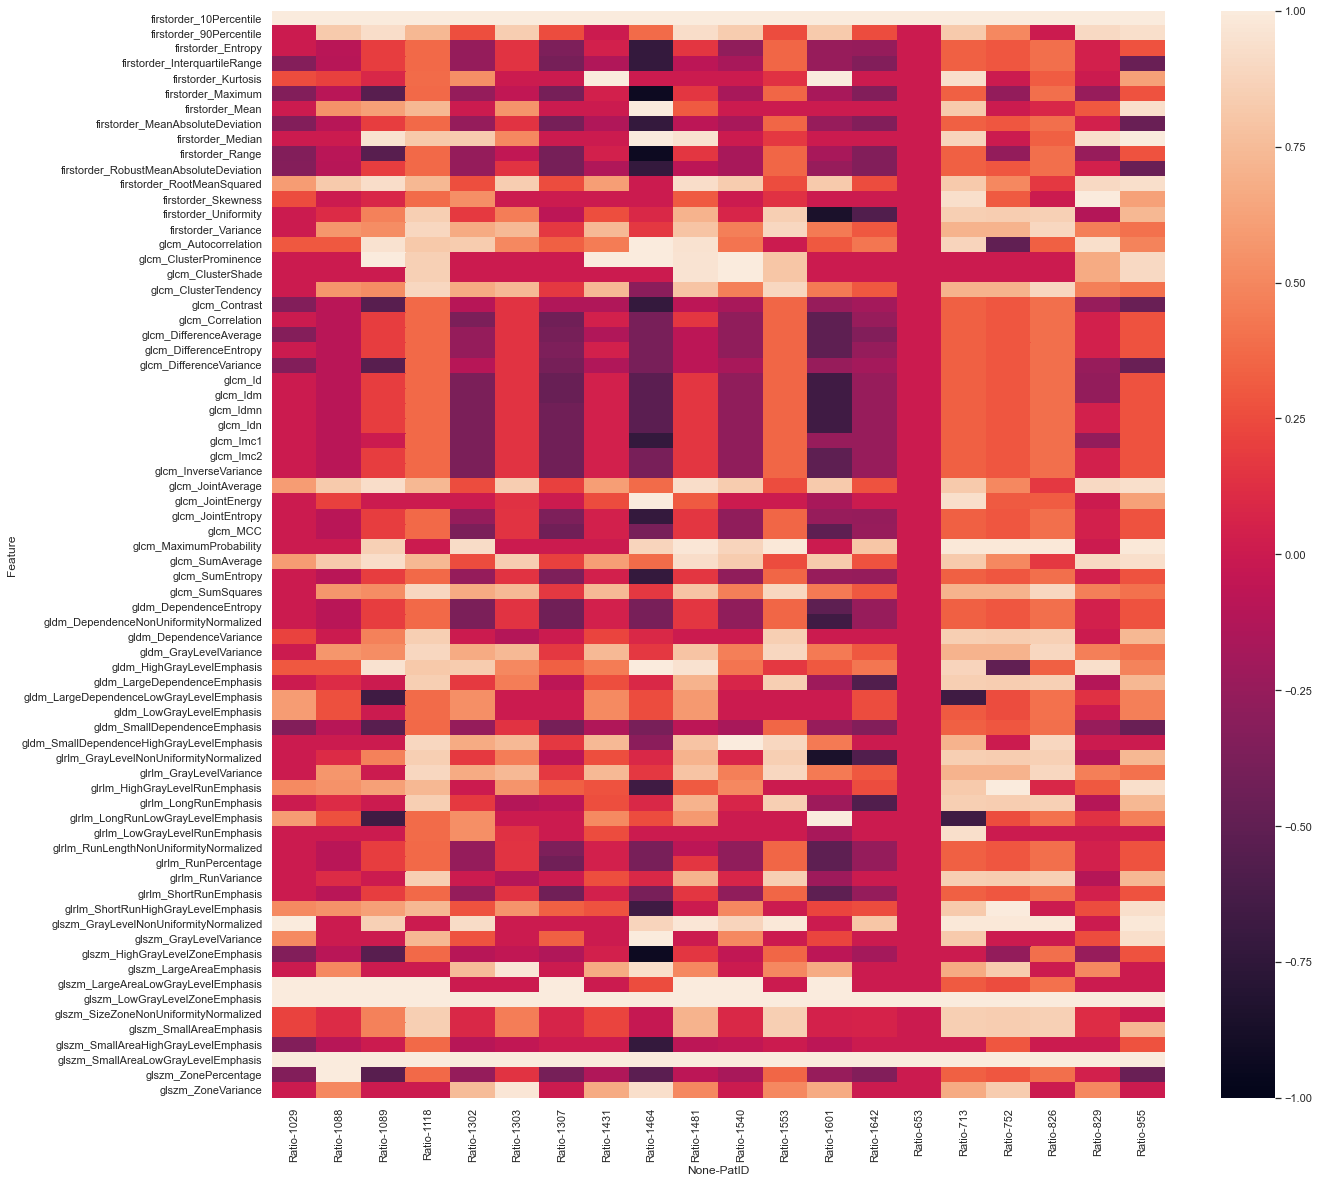

In [22]:
plt.figure(figsize=(20,20))
sns.set_theme(style = "white")
#plt.title("Clustered ft pairs - {} ({} - t = {})".format(n, cluster_method, str(t_val)), fontsize = 40)
#sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df_matrix, vmin=-1, vmax=1)
plt.savefig(out_dir + n + "_t" + str(t_val) + "_" + cluster_method + ".png")
plt.show()    